# README

This jupyter notebook supports the publication [Gene expression has more power for predicting in vitro cancer cell vulnerabilities than genomics](https://www.biorxiv.org/content/10.1101/2020.02.21.959627v3) by Dempster et al., currently available as a preprint. In addition to Jupyter, it requires a python3 kernel with h5py, matplotlib, seaborn, numpy, pandas, scipy, sklearn, and statsmodels installed. Pandas versions after 0.21 may raise missing label errors with .loc.

This script also requires the supplementary data for the manuscript be downloaded from fighshare and unzipped into a local directory. Make sure to edit the cell at 4.1: Setup Directories so the figshare variable points to this directory.

If you start by running sections 1-4, you should be able to run any of the other sections independently in any order. However, this isn't guaranteed. To run the last section (discussion question), you will also need supplementary table 2 from [Iorio et. al. (2016)](https://doi.org/10.1016/j.cell.2016.06.017) saved locally as a csv.

# Imports

In [1]:
from IPython.core.display import display, HTML 
display(HTML(
    "<style>.container { width:55% !important;\
    } div.output_wrapper .output { padding-left: 14px; }</style>"
))

In [2]:
#utility
import os
from os.path import join
import copy
import h5py

#data
import numpy as np
import pandas as pd

#plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FormatStrFormatter
import graphviz
from graphviz import Source
from adjustText import adjust_text
sns.set_style({'figure.facecolor': 'white'})
%matplotlib inline

#statistics and ML
from scipy.stats import pearsonr, spearmanr, gaussian_kde, ttest_ind
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import KFold
from statsmodels.stats.multitest import fdrcorrection

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Utility Functions

In [3]:
def binplot(x, y, binned_axis='x', nbins=10, endpoints=None, right=False, axis=None, colors=None, 
            cbar_label='Number Samples', **kwargs):
    '''
    creates a plot with values binned into boxes along one axis. 
    Params:
        x: iterable of numbers indicating position on x axis
        y: iterable of numbers indicating position on y axis. 
        binned_axis (str): 'x' or 'y', the axis to bin ('x' default)
        nbins (int): number of discrete bins that will be created
        endpoints (None or tuple of two numbers): The right/top edge of the first bin and the left/bottom edge of the last bin. If provided,
                the first and last bins will include points in [-infinity, endpoints[0]] and [endpoints[1], +infinity] respectively. Other bins
                will be evenly spaced between them. If endpoints is None (default), bins will be evenly spaced between the minimum and maximum
                data points.
        right (bool): whether points falling on an edge are included in the left or right bin.
        axis (None or pyplot.Axis): axis to draw plot on (default or None draws to current axis)
        colors (None or str or iterable of RGBA values): color palette used to color the bins
    Additional keyword arguments are passed to pyplot.boxplot.
    '''
    
    mask = pd.notnull(x) & pd.notnull(y)
    x = np.array(x)[mask]
    y = np.array(y)[mask]
    if colors is None:
        colors = "viridis"
        
    if binned_axis == 'x':
        unbinned = 'y'
        vert = True
    elif binned_axis == 'y':
        unbinned = 'x'
        vert = False
    else:
        raise ValueError("binned_axis must be 'x' or 'y'")
        
    if isinstance(x, pd.Series) and isinstance(y, pd.Series):
        assert len(set(x.index) & set(y.index)) > 2, "x and y lack common indices"
    else:
        assert len(x) == len(y), "if x and y are not Series, they must be the same length"
        
    df = pd.DataFrame({'x': x, 'y': y})
    
    if endpoints is None:
        bins = np.linspace(df[binned_axis].min()-1e-12, df[binned_axis].max()+1e-12, nbins+1)
        space = bins[2] - bins[1]
        medians = .5*(bins[1:] + bins[:-1])
    else:
        bins = [-np.inf] + list(np.linspace(endpoints[0], endpoints[1], nbins-1)) + [np.inf]
        space = bins[2] - bins[1]
        medians = np.array(
            [bins[1] - .5*space] + list(.5*np.array(bins[2:-1]) + .5*np.array(bins[1:-2])) + [bins[-2] + .5*space]
        )
        
    digits = np.digitize(df[binned_axis], bins, right=right).astype(np.int)

    if any(digits > nbins):
        print(df[binned_axis][digits > nbins])
        assert False
    df[binned_axis] = medians[digits-1]
    
    if axis is None:
        axis=plt.gca()
    else:
        plt.sca(axis)
    vals = sorted([val for val in sorted(medians) if (df[binned_axis] == val).sum() > 0])
    
    boxes = plt.boxplot(x=[df[df[binned_axis] == val][unbinned]
                   for val in vals
                  ], 
                positions=vals, widths=[.9*space]*len(vals), patch_artist=True, vert=vert,

                **kwargs)
    
    counts = df[binned_axis].value_counts().loc[medians].fillna(0)
    normer = LogNorm(vmin=0)
    normer.autoscale(counts.values)
    cvals = normer(counts.values)
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors)
        colors = [cmap(v) for v in cvals]
    for box, color in zip(boxes['boxes'], colors):
        box.set_facecolor(color)

        
    if binned_axis == 'x':
        axis.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if not endpoints is None:
            plt.xticks(bins[1:-1])
        else:
            plt.xticks(bins)
    else:
        axis.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if not endpoints is None:
            plt.yticks(bins[1:-1])
        else:
            plt.yticks(bins)
    if binned_axis == 'x':
        plt.xlim(bins[1] - 1.2*space, bins[-2] + 1.2 * space)
    else:
        plt.ylim(bins[1] - 1.2*space, bins[-2] + 1.2 * space)

    try:
        mappable=ScalarMappable(norm=normer, cmap=cmap)
        mappable.set_array(colors)
        plt.gcf().colorbar(mappable, ax=plt.gca(), label=cbar_label)
    except Exception as e:
        print(e)
        pass

    return axis

In [4]:
def squareplot(x, y, size=5, axis=None, plot_function=plt.scatter, line_kws={'lw': .5, 'linestyle': 'dashed', 'color': 'black'}, **kwargs):
    if axis is None:
        axis = plt.gca()
    fig = axis.figure
    fig.set_size_inches(size, size+.5)
    plt.sca(axis)
    axis.set_aspect('equal')
    plot_function(x, y, **kwargs)
    xlim = axis.get_xlim()
    ylim = axis.get_ylim()
    mmin = min(xlim[0], ylim[0])
    mmax = max(xlim[1], ylim[1])
    plt.plot([mmin, mmax], [mmin, mmax], **line_kws)

In [5]:
def write_hdf5(df, filename):
    if os.path.exists(filename):
        os.remove(filename)
    dest = h5py.File(filename)

    try:
        dim_0 = [x.encode('utf8') for x in df.index]
        dim_1 = [x.encode('utf8') for x in df.columns]

        dest_dim_0 = dest.create_dataset('dim_0', track_times=False, data=dim_0)
        dest_dim_1 = dest.create_dataset('dim_1', track_times=False, data=dim_1)
        dest.create_dataset("data", track_times=False, data=df.values)
    finally:
        dest.close()

def read_hdf5(filename):
    src = h5py.File(filename, 'r')
    try:
        dim_0 = [x.decode('utf8') for x in src['dim_0']]
        dim_1 = [x.decode('utf8') for x in src['dim_1']]
        data = np.array(src['data'])

        return pd.DataFrame(index=dim_0, columns=dim_1, data=data)
    finally:
        src.close()

# Data Loading

## Setup Directories

In [6]:
# point this to a directory where you have extracted the figshare files
figshare = "figshare"
if not os.path.isdir(figshare):
    assert False, "Figshare directory not found, please set it"
#generated figure panels will be put in a local directory called "figures"
if not os.path.isdir("figures"):
    os.mkdir("figures")

## Main read-in

In [7]:
data_names = ['Achilles', 'Score', 'RNAi', 'PRISM', 'GDSC17']

In [8]:
replacement = {
    'KitchenSink': 'All Features',
    'AllExpression': 'All Expression',
    'AllGenomics': 'All Genomics',
    'CN': 'Copy Number',
    'Histology': 'Tissue',
    'Methylation + Exp': 'Methylation+Exp',
}

In [9]:
main = {}
for name in data_names:
    print('loading %s' %name)
    main[name] = {
        'y': read_hdf5(join(figshare, name+"Target.hdf5")),
        'summary': pd.read_csv(join(figshare, name+"Summary.csv"))\
                    .replace(replacement)\
                    .set_index(['model', 'gene'])\
                    .sort_index(),
        'EN_score': pd.read_csv(join(figshare, name+"ENAdditionScore.csv"), index_col=0),
        
    }

loading Achilles
loading Score
loading RNAi
loading PRISM
loading GDSC17


In [10]:
for name in data_names:
    main[name]['EN_score'].index = main[name]['EN_score'].index.astype(str)
    
main['GDSC17']['summary'].reset_index(inplace=True)
main['GDSC17']['summary']['gene'] = main['GDSC17']['summary']['gene'].astype(str)
main['GDSC17']['summary'].set_index(['model', 'gene'], inplace=True)
main['GDSC17']['summary'].sort_index(inplace=True)

In [11]:
for name in data_names:
    if not name == "PRISM":
        continue
    print(name)
    pvals = []
    rhos = []
    y = main[name]['y']
    pred = read_hdf5(join(figshare, name+"AllFeaturePredictions.hdf5"))
    for col in pred:
        if not col in y:
            print('%s missing in y' % col)
            continue
        shared = sorted(set(pred[col].dropna().index) & set(y[col].dropna().index))
        rho, p = pearsonr(y.loc[shared, col], pred.loc[shared, col])
        pvals.append(p)
        rhos.append(rho)
    fdrs = fdrcorrection(pvals, 0.05)[1]
    fdrs = fdrs[np.array(rhos) >= .4]
    print('\tFDR at 0.4 Pearson Correlation or higher: %1.2E' % fdrs.max())

PRISM
	FDR at 0.4 Pearson Correlation or higher: 6.21E-21


In [12]:
for name in data_names:
    main[name]['lines'] = main[name]['y'].index
all_lines = set.union(*[set(main[name]['lines']) for name in data_names])

## Removed Features

In [13]:
removed_features = {name: pd.read_csv(join(figshare, name+"FeatureDropScore.csv"), index_col=0)['pearson_score']
                for name in data_names}
removed_features['GDSC17'].index = [str(s) for s in removed_features['GDSC17'].index]

## Identifying SSV perturbations

In [14]:
for name in data_names:
    try:
        normLRT = pd.read_csv(join(figshare, name + "NormLRT.csv"), index_col=0)['NormLRT']\
                    .reindex(index=main[name]["y"].columns)\
                    .sort_values()\
                    .dropna()
        ssv = normLRT.index[-100:]
    except FileNotFoundError:
        ssv = main[name]['y'].std().sort_values().dropna().index[-100:]
    main[name]['SSV'] = ssv

## Other data

### Gene relations

In [15]:
gene_relations = pd.read_csv(join(figshare, "GeneRelationships.csv"), index_col=0)

### Lineages

In [16]:
lineages = pd.read_csv(join(figshare, "DepMapSampleInfo.csv")).set_index("DepMap_ID")

### CFE

In [17]:
cfe = read_hdf5(join(figshare, "ApproximateCFE.hdf5"))

### Additional Drug Annotations

In [18]:
def make_title(s):
    try:
        return s[0].upper() + s[1:]
    except:
        return s

In [19]:
for name in data_names:
    try:
        main[name]['pert_info'] = pd.read_csv(join(figshare, name+"PerturbationInfo.csv"),
                                             index_col=0)
        main[name]['pert_info'].index = [str(s) for s in main[name]['pert_info'].index]
    except FileNotFoundError:
        continue

In [32]:
print('PRISM drug categories')
counts = main['PRISM']['pert_info']['disease.area'].value_counts()
oncology_uses = [s for s in counts.index if "oncology" in s]
print(counts[oncology_uses].sum())

PRISM drug categories
112


### Greedy Feature Addition Scores

In [33]:
greedy_score = {}
for name in data_names:
    greedy_score[name] = pd.read_csv(join(figshare, name+'RFAdditionScore.csv'), index_col=0)
    greedy_score[name].index = [str(s).split('::')[0] for s in greedy_score[name].index]

# Fig.1: Summarizing data sets

## Basic facts

In [34]:
lineage_counts = {}
unique_lin = lineages.reindex(index=all_lines).dropna(how='all').lineage.dropna().unique()
for name in data_names:
    lineage_counts[name] = lineages.reindex(index=main[name]['y'].index).dropna(how='all'
        ).lineage.value_counts().reindex(index=unique_lin).fillna(0)
lineage_counts = pd.DataFrame(lineage_counts)

In [35]:
for name in data_names:
    main[name]['measurements_predicted'] = main[name]['y'].notnull().sum().sum()
print('predicted measured responses: %i' % (sum([main[name]['measurements_predicted'] 
                                            for name in data_names])))
print('total unique cell lines: %i' %len(all_lines))
print("Cell lines per dataset")
for name in data_names:
    print('\t' + name, main[name]['y'].shape[0])
print("Perturbations per dataset")
for name in data_names:
    print('\t' + name, main[name]['y'].shape[1])

predicted measured responses: 28514827
total unique cell lines: 1084
Cell lines per dataset
	Achilles 693
	Score 241
	RNAi 655
	PRISM 571
	GDSC17 674
Perturbations per dataset
	Achilles 18333
	Score 17799
	RNAi 17309
	PRISM 4686
	GDSC17 255


In [36]:
print("Performance per dataset")
for name in data_names:
    print('\t' + name, 'Median %1.4f, above 0.4: %1.4f' % (
        main[name]['summary'].loc['All Features'].overall_pearson.median(),
        (main[name]['summary'].loc['All Features'].overall_pearson > .4).mean()
    )
         )
print("Performance per dataset - SSV")
for name in data_names:
    print('\t' + name, 'Median %1.4f, above 0.4: %1.4f' % (
        main[name]['summary'].loc['All Features'].loc[main[name]['SSV']].overall_pearson.median(),
        (main[name]['summary'].loc['All Features'].loc[main[name]['SSV']].overall_pearson > .4).mean()
    )
         )

Performance per dataset
	Achilles Median 0.1017, above 0.4: 0.0268
	Score Median 0.0721, above 0.4: 0.0184
	RNAi Median 0.2080, above 0.4: 0.0484
	PRISM Median 0.0480, above 0.4: 0.0222
	GDSC17 Median 0.3866, above 0.4: 0.4627
Performance per dataset - SSV
	Achilles Median 0.4905, above 0.4: 0.6500
	Score Median 0.2653, above 0.4: 0.3000
	RNAi Median 0.3963, above 0.4: 0.5000
	PRISM Median 0.3339, above 0.4: 0.3700
	GDSC17 Median 0.4067, above 0.4: 0.5300


In [37]:
#len(all_samples)

## 1a: Lineage Representation

In [38]:
color_scheme = {
    'all_genes': [.1, .7, .55, 1],
    'SSVs': [.6, .2, .5, 1],
}

In [39]:
colors =  [
    'mediumvioletred', 'darkolivegreen', 'mediumpurple', 'green', 
    'lightsalmon', 'brown', 'chartreuse', 'hotpink', 
    'deepskyblue', 'darkseagreen','deeppink', 'skyblue', 
    'crimson', 'limegreen', 'orangered', 'blueviolet', 
    'darkorange', 'darkkhaki','red', 'gray', 
    'springgreen', 'goldenrod', 'mediumblue', 'palegreen',
    'lemonchiffon', 'coral', 'tomato', 'cyan', 'purple',
    [.4, .7, .1], [0, .3, .3], [.7, .7, .4]
][:len(unique_lin)]
colors = sns.cubehelix_palette(len(unique_lin), rot=8.5, dark=.3, light=.8, hue=.8)

In [40]:
def stacked_bar(seq, colors, labels=False):
    bottom = 0
    if labels:
        labels = seq.index
    else:
        labels = [None]*len(seq)
    for i, val in enumerate(seq):
        plt.bar(y=0, height=1, x=bottom, width=val, align='edge',
                    color=colors[i], label=labels[i])
        if not pd.isnull(val):
            bottom += val
    sns.despine(top=True, right=True)
    sns.despine(left=True)
    plt.yticks([])

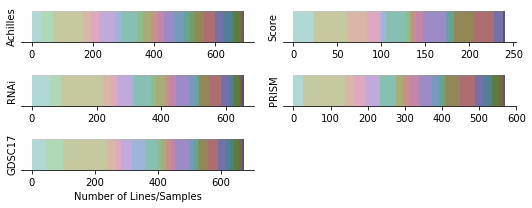

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(7.5, 3))
axs = [axs[i, j] for i in range(3) for j in range(2)]
for name, ax in zip(data_names, axs):
    plt.sca(ax)
    stacked_bar(lineage_counts[name], colors, name==name)
    plt.xlabel('')
    plt.ylabel(name, rotation=90)

fig.delaxes(axs[-1])

axs[-2].set_xlabel("Number of Lines/Samples")
plt.tight_layout()
#plt.subplots_adjust(right=.65, wspace=1)
plt.savefig('figures/lineage_breakdown.png', dpi=600)

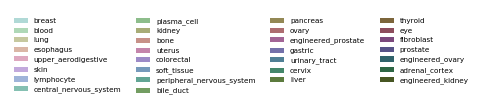

In [42]:
rects = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
plt.legend(rects, unique_lin, ncol=4, loc=(0, 0), frameon=False, fontsize=7.2)
plt.gcf().set_size_inches((7.5, 1.6))
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("figures/lineage_breakdown_legend.png", dpi=600)

## 1b: Number Perturbations in Datasets

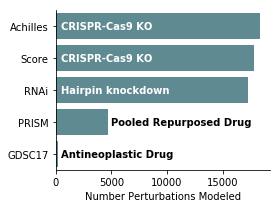

In [43]:
nperturbations = pd.Series({
    name: main[name]['y'].shape[1]
    for name in data_names
})
plt.close('all')
plt.figure(figsize=(4, 3))
sns.barplot(y=nperturbations.index, x=nperturbations.values, 
            palette=sns.cubehelix_palette(rot=0, start=-.5, dark=.5, light=.5))
plt.text(s='CRISPR-Cas9 KO', x=500, y=0.1, color='white', fontdict={'weight': 'bold'})
plt.text(s='CRISPR-Cas9 KO', x=500, y=1.1, color='white', fontdict={'weight': 'bold'})
plt.text(s='Hairpin knockdown', x=500, y=2.1, color='white', fontdict={'weight': 'bold'})
plt.text(s='Pooled Repurposed Drug', x=5000, y=3.1, color='black', fontdict={'weight': 'bold'})
plt.text(s='Antineoplastic Drug', x=500, y=4.1, color='black', fontdict={'weight': 'bold'})
#plt.xscale('log')
sns.despine(top=True, right=True)
plt.xlabel("Number Perturbations Modeled")
plt.tight_layout()
plt.savefig("figures/perturbation_counts.png", dpi=600)

## 1c: Number Features for Omics Types

In [44]:
feat = read_hdf5(join(figshare, "AchillesFeatures.hdf5"))
nfeatures = pd.Series({
    'Mutation': len([s for s in feat if s[-3:] in ('Hot', 'Dam', 'Mut')]),
    'Fusion': len([s for s in feat if s.endswith("Fusion")]),
    'Expression': len([s for s in feat if s.endswith("Exp")]),
    'GSEA': len([s for s in feat if s.endswith("GSEA")]),
    'Tissue': len([s for s in feat if s.endswith("Cell")]),
    'Copy Number': len([s for s in feat if s.endswith("CN")]),
    'Methylation': len([s for s in feat if s[-7:] in ('MethTSS', 'MethCpG')])
})
del feat

In [45]:
nfeatures['CFE'] = cfe.shape[1]
nfeatures.sort_values(ascending=False, inplace=True)

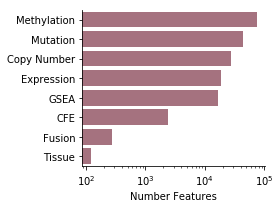

In [46]:
plt.close('all')
plt.figure(figsize=(4, 3))
sns.barplot(y=nfeatures.index, x=nfeatures.values, palette=sns.cubehelix_palette(rot=0, start=.8, dark=.5, light=.5))
plt.xscale('log')
sns.despine(top=True, right=True)
plt.xlabel("Number Features")
plt.tight_layout()
plt.savefig("figures/feature_counts.png", dpi=600)

# Fig 2: Overall Performance

## Fig 2b: Performance with All

Achilles overall median 0.102, SSV median 0.490,  all above 0.4 0.027, SSV above 0.4 0.650
Score overall median 0.072, SSV median 0.265,  all above 0.4 0.018, SSV above 0.4 0.300
RNAi overall median 0.208, SSV median 0.396,  all above 0.4 0.048, SSV above 0.4 0.500
PRISM overall median 0.048, SSV median 0.334,  all above 0.4 0.022, SSV above 0.4 0.370
GDSC17 overall median 0.387, SSV median 0.407,  all above 0.4 0.463, SSV above 0.4 0.530


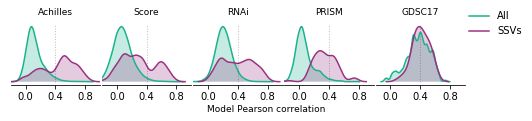

In [47]:
plt.close('all')
fig, axs = plt.subplots(1, len(data_names), figsize=(7.5, 1.6))
for name, ax in zip(data_names, axs):
    plt.sca(ax)
    sns.kdeplot(main[name]['summary'].loc['All Features']['overall_pearson'], 
                label='All', shade=True, color=color_scheme['all_genes'], bw=.02, legend=False)
    sns.kdeplot(main[name]['summary'].loc['All Features'].loc[
            main[name]['SSV']
        ]['overall_pearson'], 
                label='SSVs', shade=True, color=color_scheme['SSVs'], bw=.05,
               legend=False)
    print(name, 'overall median %1.3f, SSV median %1.3f,  all above 0.4 %1.3f, SSV above 0.4 %1.3f' % (
        main[name]['summary'].loc['All Features']['overall_pearson'].median(),
        main[name]['summary'].loc['All Features'].loc[main[name]['SSV']]['overall_pearson'].median(),
        (main[name]['summary'].loc['All Features']['overall_pearson'] > .4).mean(),
        (main[name]['summary'].loc['All Features'].loc[main[name]['SSV']]['overall_pearson'] > .4).mean()
        ))
    sns.despine(top=True, right=True)
    if name == 'CRISPR':
        plt.xlabel('')
        plt.legend(frameon=False)
    plt.xlim(-.2, 1)
    plt.xticks([ 0,  .4, .8])
    plt.title(name, fontsize=9)

    for x, color in zip([.4], ['black']):
         plt.plot([x, x], [0, plt.gca().get_ylim()[-1]], ':', color=color, lw=1, alpha=.25)
    sns.despine(left=True)
    plt.yticks([])
    
custom_lines = [Line2D([0], [0], color=color_scheme['all_genes']),
                Line2D([0], [0], color=color_scheme['SSVs'])]
plt.legend(custom_lines, ['All', 'SSVs'], loc=(1, .7), frameon=False)
    
fig.text(.5, .005, "Model Pearson correlation", fontsize=9, ha='center')
plt.tight_layout()
plt.subplots_adjust(wspace=.02)
plt.savefig('figures/distro_summary.png', dpi=600)

## Fig 2c: Best out of All Genomics, All Expression

In [48]:
perf_expression = {name: main[name]['summary'].loc['All Expression']['overall_pearson']
                               for name in data_names}

In [49]:
perf_genomics = {name: main[name]['summary'].loc['All Genomics']['overall_pearson']
                               for name in data_names}

In [50]:
perf_diff = {name: perf_expression[name] - perf_genomics[name]
             for name in data_names}

In [51]:
perf_max = {name: pd.DataFrame({'exp': perf_expression[name], 'gen': perf_genomics[name]}).max(axis=1)
             for name in data_names}

Achilles total good: 464 expression best: 388 expression best percent: 0.8362068965517241
Score total good: 320 expression best: 215 expression best percent: 0.671875
RNAi total good: 788 expression best: 695 expression best percent: 0.881979695431472
PRISM total good: 96 expression best: 92 expression best percent: 0.9583333333333334
GDSC17 total good: 117 expression best: 112 expression best percent: 0.9572649572649573


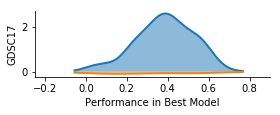

In [52]:
for name in data_names:
    plt.close('all')
    plt.gcf().set_size_inches(4, 1.5)
    grid = np.linspace(min(perf_max[name])-.05, max(perf_max[name])+.05, 200)
    
    upper = perf_diff[name].loc[lambda x: x > 0].index
    kde = gaussian_kde(perf_max[name].loc[upper])
    scale = len(upper) *1.0/len(perf_max[name])
    vals = scale * kde(grid)
    plt.plot(grid, vals, lw=2, label="Expression Best")
    plt.fill_between(grid, vals, alpha=.5)
    
    lower = perf_diff[name].loc[lambda x: x <= 0].index
    kde = gaussian_kde(perf_max[name].loc[lower])
    scale = len(lower) *1.0/len(perf_max[name])
    vals = -scale * kde(grid)
    plt.plot(grid, vals, lw=2, label="Genomics Best")
    plt.fill_between(grid, vals, alpha=.5)
    
    good = perf_max[name].loc[lambda x: x > 0.4].index
    print(name, 'total good:', len(good), 'expression best:', len(set(good) & set(upper)),
         'expression best percent:', len(set(good)& set(upper))/len(good))
    
    if name == 'Achilles':
        plt.legend(loc="upper right", frameon=False)
    
    if name in ('PRISM', 'GDSC17'):
        plt.xlabel("Performance in Best Model")
        plt.gcf().set_size_inches(4, 1.7)
    plt.ylabel(name)
    plt.yticks([0, 2])
    plt.xlim(-.25, .9)
    
    plt.tight_layout()
    sns.despine(right=True, top=True)
    
    plt.savefig('figures/mean_v_diff_%s.png' % name, dpi=600)

## Fig 2d: Predictors > 0.4 with Expression or Genomics

Achilles total genes with fair models 464 total fair with exp 431 total fair with genomics 187 overlap 154
Score total genes with fair models 320 total fair with exp 244 total fair with genomics 168 overlap 92
RNAi total genes with fair models 788 total fair with exp 755 total fair with genomics 318 overlap 285
PRISM total genes with fair models 96 total fair with exp 94 total fair with genomics 46 overlap 44
GDSC17 total genes with fair models 117 total fair with exp 117 total fair with genomics 65 overlap 65


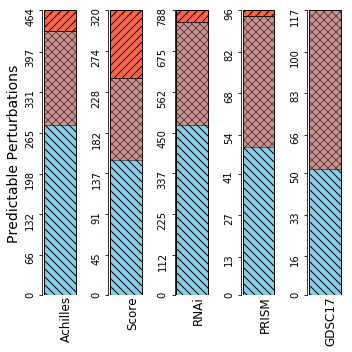

In [53]:
plt.close('all')
fig, axs = plt.subplots(1, len(data_names), figsize=(5.0, 5.0))

for name, ax in zip(data_names, axs):
    df = main[name]['summary']
    plt.sca(ax)
    sub = df.loc[(['All Expression', 'All Genomics'], slice(None)), slice(None)]
    fair_models = sub[sub.overall_pearson > .4].reset_index()
    ratio_exp_in_fair_models = fair_models.model.isin(['All Expression', 'Expression']).sum()
    overlap = fair_models.groupby('gene').agg(lambda x: len(x) == 2).astype(np.int)['model'].sum()
    total_fair = len(fair_models)
    print(name, 'total genes with fair models', fair_models.gene.nunique(),
          'total fair with exp', ratio_exp_in_fair_models,
          'total fair with genomics', fair_models.model.isin(['All Genomics', 'Mutation']).sum(),
          'overlap', overlap
         )

    plt.bar(x=0, width=.5, bottom=0, height=ratio_exp_in_fair_models, color='skyblue',
           hatch='\\\\\\', edgecolor='black')
    plt.bar(x=0, width=.5, 
            bottom=ratio_exp_in_fair_models , 
            height=total_fair - ratio_exp_in_fair_models - overlap,
            color='tomato',
            hatch='///',
             edgecolor='black',
           alpha=1)
    plt.bar(x=0, width=.5, 
            bottom=ratio_exp_in_fair_models - overlap, 
            height=overlap,
            color='tomato',
            hatch='///',
             edgecolor='black',
           alpha=.5)
    sns.despine(bottom=True, top=True, right=True)
    _ = plt.xticks([])
    plt.ylim(0, total_fair - overlap)
    plt.ylabel('')
    if name == data_names[0]:
        plt.ylabel("Predictable Perturbations", fontsize=14)
    plt.yticks(np.linspace(0, total_fair - overlap, 8).astype(np.int), rotation=90)
    plt.text(0, 0, name, rotation=90, horizontalalignment='left', verticalalignment='top',
            fontsize=12)
plt.tight_layout()
plt.savefig('figures/one_bar.png', dpi=600)

In [54]:
print('all', 464 + 320 + 788 + 96 + 117)

all 1785


In [55]:
print('expression', 431 + 244 + 755 + 94 + 117)

expression 1641


In [56]:
print('genomics', 187 + 168 + 318 + 46 + 65)

genomics 784


In [57]:
print('overlap', 154 + 92 + 285 + 44 + 65)

overlap 640


In [58]:
1641 - 640

1001

In [59]:
784 - 640

144

# Fig 2-1: RF/EN comparison

Achilles 100
Score 100
RNAi 100
PRISM 100
GDSC17 100
RF beats EN 355 EN beats RF 145


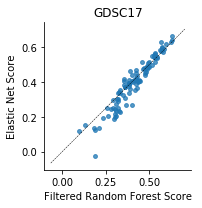

In [60]:
total_rf_better = 0
total_en_better = 0
for name in data_names:
    plt.close('all')
    x = main[name]['summary'].loc['All Features'].loc[main[name]['SSV'], 'overall_pearson']
    y = main[name]['EN_score'].loc[main[name]['SSV']]['all']
    print(name, y.notnull().sum())
    squareplot(x, y, 
               linewidth=1, alpha=.75, s=15
              )
    total_rf_better += (x > y).sum()
    total_en_better += (y > x).sum() 
    sns.despine(top=True, right=True)
    plt.xlabel("Filtered Random Forest Score")
    plt.ylabel("Elastic Net Score")
    plt.title(name)
    plt.gcf().set_size_inches(3, 3)
    plt.tight_layout()
    plt.savefig("figures/en_comparison_%s.png" % name, dpi=600)
print('RF beats EN', total_rf_better, 'EN beats RF', total_en_better)

# Fig 2-2: Known Oncogenes

In [61]:
oncogenes = pd.read_csv(join(figshare,"OncoKB_oncogenes.csv"))['gene']

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


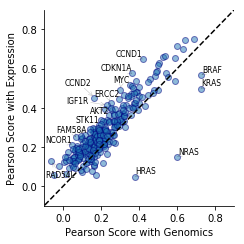

In [62]:
for name in 'Achilles', 'Score', 'RNAi':
    summary = main[name]['summary']
    oncogene_list = sorted(set(oncogenes) & set(summary.index.get_level_values(1)))
    plt.close('all')
    plt.figure(figsize=(3.5, 3.5))
    plt.scatter(
        summary.loc['All Genomics'].loc[oncogene_list].overall_pearson, 
        summary.loc['All Expression'].loc[oncogene_list].overall_pearson,
        edgecolor="navy", alpha=.5
    )
    plt.plot([-1, 1], [-1, 1], '--', color='black')
    plt.xlim(-.1, .9)
    plt.ylim(-.1, .9)
    plt.xlabel('Pearson Score with Genomics')
    plt.ylabel('Pearson Score with Expression')
    plt.tight_layout()
    interesting = list((
        summary.loc['All Genomics'].loc[oncogene_list, 'overall_pearson']
                   - summary.loc['All Expression'].loc[oncogene_list, 'overall_pearson']
                  ).abs().sort_values().index[-15:])
    interesting = sorted(set(interesting + ['BRAF (673)']))
    
    texts = [plt.text(summary.loc['All Genomics'].loc[gene].overall_pearson,
                     summary.loc['All Expression'].loc[gene].overall_pearson,
                     gene.split(' ')[0], fontsize=7.5)
                for gene in interesting]
    adjust_text(texts, x=summary.loc['All Genomics'].loc[oncogene_list].overall_pearson,
                y=summary.loc['All Expression'].loc[oncogene_list].overall_pearson,
                arrowprops=dict(arrowstyle='->', color="black", alpha=.25, lw=.5)
               )
    sns.despine(top=True, right=True)
    plt.savefig("figures/oncogene_scatter%s.png" %name, dpi=600)

# Fig. 2-3: Benefit of Additional Omics

In [68]:
def get_performance_change(model_results, model1, model2, 
                           criterion='overall_pearson', min_original=0, max_entries=np.inf,
                           name_map=None
                          ):
    ind = pd.Index(set(model_results.loc[model2].index) & set(model_results.loc[model1].index))
    change = pd.DataFrame({'change': 
                model_results.loc[model2].loc[ind][criterion] - \
                model_results.loc[model1].loc[ind][criterion]
                          })
    change['original'] = model_results.loc[model1].loc[ind][criterion]
    change = change[change.index.to_series().apply(lambda x: '&' not in x).values]
    ind = model_results.loc[model1].query('%s > %f' %(criterion, min_original)).index
    change = change.loc[ind]
    if max_entries < np.inf:
        change = change.sort_values(['original'], ascending=False).iloc[0:max_entries]
    out = change.sort_values('change').reset_index().rename(columns={'index': 'gene'})
    if not name_map is None:
        out['gene'] = name_map.loc[out.gene].values
    return out

## Fig 2-3a: Adding Expression to Genomics

Achilles median change 0.052643575144028176 0.08778665803759121
total median percent change: 0.087787
Score median change 0.012509481681879764 0.02120364490420176
total median percent change: 0.059327


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


RNAi median change 0.03631427034409723 0.06174892832792064
total median percent change: 0.060411
PRISM median change 0.048318096181044184 0.09536771886726772
total median percent change: 0.077613
GDSC17 median change 0.04725128429583264 0.08903281007040745
total median percent change: 0.080602


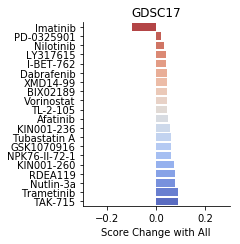

In [69]:
pct_change = []
for name in data_names:
    plt.close('all')
    plt.figure(figsize=(3.5, 3.5))
    name_map = None
    if name in ['PRISM', 'GDSC17']:
        name_map = main[name]['pert_info']['Name'].drop_duplicates().replace(
            {'bis(maltolato)oxovanadium(IV)': 'BMOV'})
    
    data = get_performance_change(main[name]['summary'], 
                                  'All Genomics', 'All Features',
                                  criterion='overall_pearson', min_original=.4, max_entries=20,
                                  name_map=name_map
                                 )
#     if name == 'CRISPR':
#         data['gene'] = data['gene'].apply(lambda s: s.split(' ')[0])
    print(name, 'median change', data['change'].median(), 
          (data['change']/data['original']).median())
    pct_change.extend(data['change']/data['original'])
    sns.barplot(data=data, y='gene', x='change', palette='coolwarm_r')
    plt.xlabel('Score Change with All')
    plt.ylabel('')
    sns.despine(top=True, right=True)
    plt.xlim(-.3, .3)
    for tick in plt.gca().get_xticklabels():
        tick.set_rotation(0)
    plt.title(name)
    plt.tight_layout()
    #plt.subplots_adjust(right=.99)
    print("total median percent change: %f" % np.median(pct_change))
    plt.savefig('figures/adding_expression_%s.png' %name, dpi=600)

## Fig. 2-3b: Adding Genomics to Expression

Achilles median change -0.0028783779582421953 -0.003885647252359798
Score median change -0.0036250012714274527 -0.00552462893596347


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


RNAi median change 0.0029877761176769213 0.0042762560239433854
PRISM median change -0.0005317125111402587 -0.000944485616117655
GDSC17 median change -0.002603196335503377 -0.004457788141561021
-0.002714513033313444


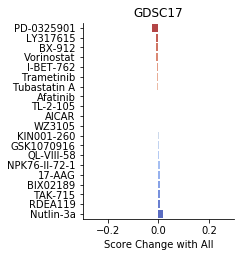

In [70]:
pct_change = []
for name in data_names:
    plt.close('all')
    plt.figure(figsize=(3.5, 3.5))
    name_map = None
    if name in ['PRISM', 'GDSC17']:
        name_map = main[name]['pert_info']['Name'].drop_duplicates().replace(
            {'bis(maltolato)oxovanadium(IV)': 'BMOV'})
        
    data = get_performance_change(main[name]['summary'], 
                              'All Expression', 'All Features',
                              criterion='overall_pearson', min_original=.4, max_entries=20,
                              name_map=name_map
                             )
    if name == 'CRISPR':
        data['gene'] = data['gene'].apply(lambda s: s.split(' ')[0])
    print(name, 'median change', data['change'].median(),
         (data['change']/data['original']).median())
    pct_change.extend(data['change']/data['original'])
    sns.barplot(data=data, y='gene', x='change', palette='coolwarm_r')
    plt.xlabel('Score Change with All')
    plt.ylabel('')
    sns.despine(top=True, right=True)
    plt.xlim(-.3, .3)
    plt.xticks([-.2, 0, .2])
    plt.tight_layout()
    plt.title(name)
    #plt.subplots_adjust(right=.99)
    plt.savefig('figures/adding_genomics_%s.png' %name, dpi=600)
print(np.median(pct_change))

# Fig. 3: Different Feature Combinations

In [63]:
models_exp = set(['All Expression',  'CN+Exp', 'Expression',
       'GSEA', 'All Features', 'Methylation+Exp',
       'Mutation+Exp'])
models_no_exp = set(['All Genomics', 'Copy Number',
       'Tissue', 
       'Methylation', 'Mutation', 'CFE', 'Fusion'
 ])

In [64]:
exp_colors = dict(zip(models_exp,
                      [
    'blue', 'royalblue', 'dodgerblue', 'deepskyblue', 'skyblue',   
             'lightskyblue', 'powderblue', 'paleturquoise'
                        ]
))

In [65]:
gen_colors = dict(zip(models_no_exp, 
    reversed(['brown', 'darkred',  'firebrick', 'red',  'tomato',  
                                        'pink', 'coral' ])
))

## Fig 3a: Number Predictors > 0.4

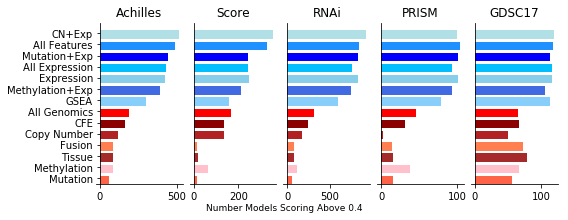

In [66]:
all_colors = copy.copy(exp_colors)
all_colors.update(gen_colors)

plt.close('all')
fig, axs = plt.subplots(1, len(data_names), figsize=(8, 3))

for name, ax in zip(data_names, axs):
    plt.sca(ax)
    df = main[name]['summary']
    n_fair_models = (df.overall_pearson > .4).groupby(level=0).sum()
    all_colors = copy.copy(exp_colors)
    all_colors.update(gen_colors)
    if name == data_names[0]:
        order = n_fair_models.sort_values(ascending=True).index
        order = [s for s in order if s in all_colors]
        vlocations = dict(zip(order, range(len(n_fair_models))))
        ind = n_fair_models.index
    n_fair_models = n_fair_models.loc[order].fillna(0)
    for model, score in n_fair_models.iteritems():
        plt.bar(bottom=vlocations[model]+.5, height=.75, x=0, width=score, 
                color=all_colors[model], align='edge')


    plt.yticks([])
    sns.despine(top=True, right=True)
    plt.gca().spines['left'].set_position('zero')
    #plt.gca().spines['bottom'].set_position('zero')
    plt.xlabel('')
    plt.ylabel('')
    if name is data_names[0]:
        #plt.xlabel("Number Models > 0.4")
        plt.yticks(range(1, len(order)+1), order)
    plt.title(name)
fig.text(.5, .005, "Number Models Scoring Above 0.4", fontsize=9, ha='center')
plt.tight_layout()
plt.subplots_adjust(wspace=.08)
plt.savefig("figures/number_fair_models.png", dpi=600)

## Fig 3b: Best Feature Combination

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Achilles 93.39774557165862
Achilles 6.602254428341384
Score 75.717017208413
Score 24.282982791586992
RNAi 96.72268907563024
RNAi 3.2773109243697474
PRISM 99.21259842519686
PRISM 0.7874015748031495
GDSC17 91.91176470588236
GDSC17 8.088235294117647


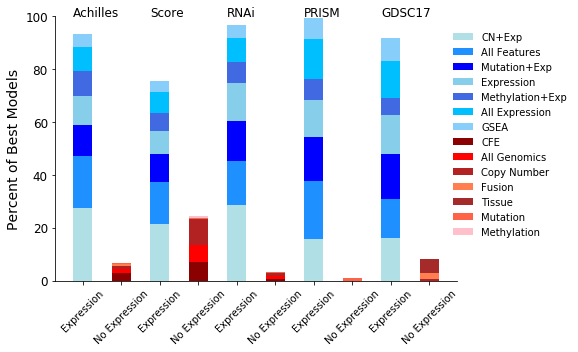

In [67]:
plt.close('all')
plt.figure(figsize=(8, 5))
x = 0
exp_order, gen_order = None, None

for name in data_names:
    plt.text(x-.5, 100, name, fontsize=12, horizontalalignment='left')
    
    summary = main[name]['summary']
    summary_restrict = summary.reset_index(
        ).set_index('model').loc[list(models_exp | models_no_exp)]
    winners = summary_restrict.groupby('gene').agg(
        lambda x: np.argmax(x['overall_pearson']))
    winners = winners.reset_index()
    winners = summary.loc[list(winners[['overall_pearson', 'gene']].itertuples(
        name=None, index=False))].reset_index().set_index('gene')

    win_pct = winners[winners.overall_pearson > .4].groupby('model').count()['overall_pearson']
    win_pct /= win_pct.sum()
    win_pct = 100*win_pct.loc[sorted(models_exp) + sorted(models_no_exp)].fillna(0)
    if exp_order is None:
        exp_order = win_pct.loc[list(models_exp)].sort_values(ascending=False).index
        gen_order = win_pct.loc[list(models_no_exp)].sort_values(ascending=False).index
    exp_win = np.cumsum(win_pct.loc[exp_order])
    gen_win = np.cumsum(win_pct.loc[gen_order])
    
    for i, index in enumerate(exp_win.index):
        label = None
        if name is data_names[0]:
            label = index
        if i == 0:
            plt.bar(x=x, width=1, bottom=0, height=win_pct[index],
                    color=exp_colors[index], label=label)
        else:
            plt.bar(x=x, width=1, bottom=exp_win.iloc[i-1], 
                    height=win_pct[index], color=exp_colors[index], label=label)
    print(name, exp_win.iloc[i])
    for i, index in enumerate(gen_win.index):
        label = None
        if name is data_names[0]:
            label = index
        if i == 0:
            plt.bar(x=x+2, width=1, bottom=0, 
                    height=win_pct[index], color=gen_colors[index], label=label)
        else:
            plt.bar(x=x+2, width=1, bottom=gen_win.iloc[i-1], 
                    height=win_pct[index], color=gen_colors[index], label=label)
    print(name, gen_win.iloc[i])     
    x += 4
        
sns.despine(top=True, right=True)
#plt.xlim(-1, 3.75)
#plt.xticks([1, 2], ['Expression', 'No Expression'], fontsize=11, rotation=45)
plt.yticks(range(0, 101, 20), fontsize=12)
plt.xticks(range(0, 20, 2), ["Expression", "No Expression"]*5, rotation=45)
plt.ylim(0, 100)
plt.ylabel('Percent of Best Models', fontsize=14)

plt.legend(frameon=False, loc=(.98, .15))
plt.tight_layout()
plt.subplots_adjust(right=.80)
plt.savefig('figures/best_model_proportion.png', dpi=600)

# Fig. 4: Predictor Sparsity

## Fig. 4a: Feature importance vs performance

In [71]:
top2_importance = pd.DataFrame(columns=['Data Set', 'Top2', 'Pearson'])
for key in data_names:
    df = main[key]['summary'].loc['All Features']
    top2_importance = top2_importance.append(pd.DataFrame({
        'Data Set': key,
        'Top2': df[['feature0_importance', 'feature1_importance']].sum(axis=1).values,
        'Pearson': df.overall_pearson.values
    }), ignore_index=True)

top2_importance['Top2'] = pd.cut(top2_importance['Top2'], bins=np.linspace(0, 1, 5))

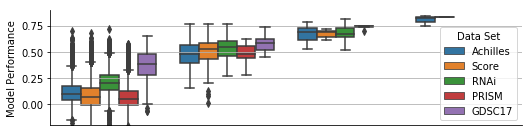

In [72]:
plt.close('all')

sns.boxplot(data=top2_importance, x='Top2', y='Pearson', hue='Data Set')
plt.xticks(np.arange(-.5, 3.7), np.round(np.arange(0, .8, .2), 1), rotation=00)
plt.gcf().set_size_inches(7.5, 2.0)
plt.xticks([])
plt.ylim(-.2, .9)
sns.despine(top=True, right=True)
plt.xlabel("")
plt.ylabel("Model Performance")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('figures/top2_importance_box.png', dpi=600, transparent=True)

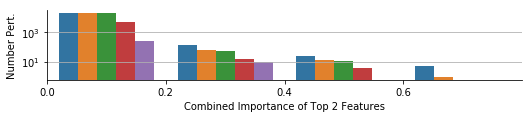

In [73]:
plt.close('all')

sns.countplot(data=top2_importance, x='Top2', hue='Data Set')
plt.xticks(np.arange(-.5, 3.0), np.round(np.arange(0, .8, .2), 1), rotation=90)
plt.gcf().set_size_inches(7.5, 1.75)
plt.grid(axis='y')
#plt.ylim(-.2, .9)
sns.despine(top=True, right=True)
plt.xlabel("Combined Importance of Top 2 Features")
plt.ylabel("Number Pert.")
plt.yscale('log')
plt.gca().get_legend().remove()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/top2_importance_bin.png', dpi=600, transparent=True)

## Fig. 4bc: Known relationships

In [74]:
gene_relations.groupby('target').partner.count().median()

29.0

In [75]:
def check_related(x):
    target = x['feature0'].split('_')[0]
    try:
        partners = gene_relations.loc[x['gene']].partner
    except KeyError:
        return False
    if isinstance(partners, str):
        partners = [partners]
    return target in list(partners) or target == x['gene']


In [76]:
for name in data_names:
    summary = main[name]['summary']
    endings = summary['feature0'].apply(lambda s: s.split('_')[-1])
    def find_end(s):
        if s.startswith('cna'):
            return 'CNA'
        else:
            return s
    endings = endings.apply(find_end)
    sig_feature = (summary['feature0_importance'] > .1)
    summary['exp_biomarker'] = ((endings == 'Exp') | (endings == 'GSEA')) & sig_feature

    summary['gen_biomarker'] = (
        (endings == 'OtherMut') |
        (endings == 'Dam') |
        (endings == 'Hot') |
        (endings == 'MethTSS') |
        (endings == 'MethCpG') |
        (endings == 'CN') |
        (endings == 'Fusion') |
        (endings == 'Meth') |
        (endings == 'CNA')
    ) & sig_feature
    
    summary['tissue_biomarker'] = (endings == 'Cell') & sig_feature

In [77]:
for name in 'Achilles', 'Score', 'RNAi':
    print(name, 'How often exp biomarker is gene\'s own exp', main[name]['summary'].loc['All Features'].query(
        'exp_biomarker')[['feature0']].apply(
            lambda x: x.feature0.split('_')[0].split(' ')[0] == x.name.split(' ')[0],
         axis=1).mean()
        )
    

Achilles How often exp biomarker is gene's own exp 0.25
Score How often exp biomarker is gene's own exp 0.11374407582938388
RNAi How often exp biomarker is gene's own exp 0.3135593220338983


In [78]:
exp_biomarker_self = {key: main[key]['summary'].loc['All Features'].query('exp_biomarker')
                     for key in data_names}

exp_biomarker_self = {key: val.apply(lambda x: x.name == x['feature0'].split('_')[0], axis=1)
                      for key, val in exp_biomarker_self.items()
                     }

In [79]:
exp_biomarker_self_sr = {key: pd.Series({
    'All Genes': val.mean(),
    'SSV': val.loc[main[key]['SSV']].mean(),
    'Pearson > 0.4': val.loc[main[key]['summary'].loc['All Features'].query('overall_pearson > .4').index].mean()
    }) for key, val in exp_biomarker_self.items()}

/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


In [80]:
is_related = {}
exp_biomarker_freq = {}
exp_biomarker_related = {}

for name in data_names:
    print(name)
    summary = main[name]['summary']
    hv = main[name]['SSV']
    
    exp_biomarker_freq[name] =  pd.Series({
            'All Genes': summary.loc['All Features'].exp_biomarker.mean(),
            'SSV': summary.loc['All Features'].loc[hv].exp_biomarker.mean(),
            'Pearson > 0.4': summary.loc['All Features'].query('overall_pearson > 0.4'
                                                           ).exp_biomarker.mean(),
        })
    print('\tMean models with key features when Pearson < .4',
          (summary.loc['All Features'].query('overall_pearson < 0.4').feature0_importance >= .1).mean()
         )
    print('\tTotal Pearson > 0.4', summary.loc['All Features'].query('overall_pearson > 0.4').shape[0])
    print('\tPearson > 0.4 Exp Biomarker', summary.loc['All Features'].query('overall_pearson > 0.4'
                                                           ).exp_biomarker.sum())
    print('\tPearson > 0.4 Gen Biomarker', summary.loc['All Features'].query('overall_pearson > 0.4'
                                                           ).gen_biomarker.sum())
    print('\tPearson > 0.4 Tiss Biomarker', summary.loc['All Features'].query('overall_pearson > 0.4'
                                                           ).tissue_biomarker.sum())
    if name in ['Achilles', 'Score', 'RNAi']:
        exp_biomarker_freq[name]['OncoKB Genes'] = summary.loc['All Features'].loc[oncogene_list].exp_biomarker.mean()
        

    if name in ['Achilles', 'Score', 'RNAi']:
        sub = summary.loc['All Features'].query('exp_biomarker').reset_index()
        is_related[name] = sub.apply(check_related, axis=1)
        is_related[name].index = sub.gene
        exp_biomarker_related[name] = pd.Series({
            'All Genes': is_related[name].mean(),
            'SSV': is_related[name].loc[hv].mean(),
            'Pearson > 0.4': is_related[name][(sub.overall_pearson > .4).values].mean(),
        })
        print(name, '\tExp biomarker is related gene', is_related[name].mean())
        print(name, '\tExp biomarker is gene\'s own exp', main[name]['summary'].loc['All Features'].query(
        'exp_biomarker')[['feature0']].apply(
            lambda x: x.feature0.split('_')[0].split(' ')[0] == x.name.split(' ')[0],
         axis=1).mean()
              
        )

Achilles
	Mean models with key features when Pearson < .4 0.013059074094832418
	Total Pearson > 0.4 491
	Pearson > 0.4 Exp Biomarker

/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


 194
	Pearson > 0.4 Gen Biomarker 22
	Pearson > 0.4 Tiss Biomarker 0


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:36: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


Achilles 	Exp biomarker is related gene 0.5078125
Achilles 	Exp biomarker is gene's own exp 0.25
Score
	Mean models with key features when Pearson < .4 0.01070345143380459
	Total Pearson > 0.4 328
	Pearson > 0.4 Exp Biomarker 75
	Pearson > 0.4 Gen Biomarker 24
	Pearson > 0.4 Tiss Biomarker 0
Score 	Exp biomarker is related gene 0.2938388625592417
Score 	Exp biomarker is gene's own exp 0.11374407582938388
RNAi
	Mean models with key features when Pearson < .4 0.006617289946576008
	Total Pearson > 0.4 837
	Pearson > 0.4 Exp Biomarker 143
	Pearson > 0.4 Gen Biomarker 14
	Pearson > 0.4 Tiss Biomarker 1
RNAi 	Exp biomarker is related gene 0.4067796610169492
RNAi 	Exp biomarker is gene's own exp 0.3135593220338983
PRISM
	Mean models with key features when Pearson < .4 0.00501964207769533
	Total Pearson > 0.4 104
	Pearson > 0.4 Exp Biomarker 27
	Pearson > 0.4 Gen Biomarker 5
	Pearson > 0.4 Tiss Biomarker 0
GDSC17
	Mean models with key features when Pearson < .4 0.043795620437956206
	Total Pear

In [81]:
sorted(exp_biomarker_related.keys())

['Achilles', 'RNAi', 'Score']

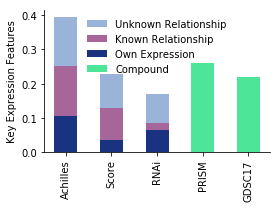

In [82]:
for subset in ['SSV', 'Pearson > 0.4']:
    plt.close('all')
    plt.figure(figsize=(4, 3.0))
    for i, key in enumerate(data_names):
        label = None

        color = (.6, .7, .85)
        if key in ['GDSC17', 'PRISM']:
            color = (.3, .9, .6)
        if i == 0:
            label='Unknown Relationship'
        elif key == 'PRISM':
            label="Compound"
        plt.bar(x=i, y=0, width=.5, height=exp_biomarker_freq[key][subset], color=color, 
               label=label)

        if key in ['GDSC17', 'PRISM']:
            continue
        if i == 0:
            label = 'Known Relationship'
        plt.bar(x=i, y=0, width=.5, 
                height=exp_biomarker_related[key][subset] * exp_biomarker_freq[key][subset], 
                color=(.65, .4, .6), label=label)

        if i == 0:
            label = 'Own Expression'
        plt.bar(x=i, y=0, width=.5, 
                height=exp_biomarker_self_sr[key][subset] * exp_biomarker_freq[key][subset], 
                color=(.1, .2, .5), label=label)


    plt.legend(frameon=False)
    plt.ylabel("Key Expression Features")
    plt.xticks(range(len(data_names)), data_names, rotation=90)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig("figures/exp_bio_all_%s.png" % subset.split(' ')[0], dpi=600)

## Fig. 4de: Only One Feature

In [83]:
keyfeature = {name: main[name]['summary'].loc['All Features']\
              .query('feature0_importance >= .1').index
             for name in data_names}
nokeyfeature = {name: main[name]['summary'].loc['All Features']\
              .query('feature0_importance < .1').index
             for name in data_names}

In [84]:
perf_ratios = pd.DataFrame(columns=['dataset', 'keyfeature', 'score'])
for name, val in greedy_score.items():
    perf_ratios = perf_ratios.append(pd.DataFrame({'dataset': name, 'keyfeature': val.index.isin(keyfeature[name]),
                                                   'score': (val['1']/val['1000']).values}),
                                    ignore_index=True)

In [85]:
perf_ratios_EN = pd.DataFrame(columns=['dataset', 'keyfeature', 'score'])
for name in data_names:
    val = main[name]['EN_score']
    perf_ratios_EN = perf_ratios_EN.append(pd.DataFrame({'dataset': name, 'keyfeature': val.index.isin(keyfeature[name]),
                                                   'score': (val['1']/val['all']).values}),
                                    ignore_index=True)

With key feature, ratio median 0.8427665176847172
Without key feature, ratio median 0.6051869283560376


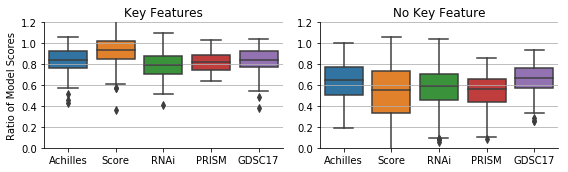

In [86]:
figure, axs = plt.subplots(1, 2, figsize=(8, 2.0))

plt.sca(axs[0])
sns.boxplot(data=perf_ratios[perf_ratios.keyfeature == 1], x='dataset', y='score')
print('With key feature, ratio median', perf_ratios[perf_ratios.keyfeature == 1]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("Ratio of Model Scores")
plt.xlabel('')
plt.title('Key Features')
plt.ylim(0, 1.2)
                                
plt.sca(axs[1])
sns.boxplot(data=perf_ratios[perf_ratios.keyfeature == 0], x='dataset', y='score')
print('Without key feature, ratio median', perf_ratios[perf_ratios.keyfeature == 0]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("")
plt.xlabel('')
plt.title('No Key Feature') 
plt.ylim(0, 1.2)
                                
                                
plt.gcf().set_size_inches(8, 2.5)
plt.tight_layout()
plt.savefig('figures/one_feature_scores.png', dpi=600)

# Fig. 4-1: Feature Ablation

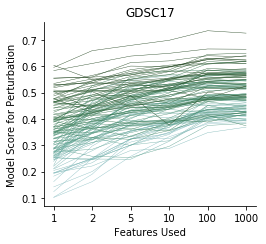

In [87]:
for name, val in greedy_score.items():
    pal = sns.cubehelix_palette(len(val), start=np.random.uniform(-2, 2), dark=.2, light=.7)
    plt.close('all')
    plt.figure(figsize=(3.8, 3.5))
    for i, ind in enumerate(val.sort_values('1').index):
        plt.plot(np.arange(val.shape[1]), val.loc[ind], color=pal[i], lw=.4)
    sns.despine()
    plt.xticks(range(val.shape[1]), val.columns)
    plt.xlabel("Features Used")
    plt.ylabel("Model Score for Perturbation")
    plt.title(name)
    plt.tight_layout()
    plt.savefig('figures/feature_addition_score_%s.png' % name, dpi=600)

In [88]:
print((perf_ratios[perf_ratios.keyfeature == 0].score > .8).mean())

0.1401938851603281


In [89]:
print((perf_ratios[perf_ratios.keyfeature == 1].score > .8).mean())

0.6201117318435754


# Fig. 4-2: Additional Feature Ablation

## Fig. 4-2a: Ratio with Two Features

In [90]:
perf_ratios2 = pd.DataFrame(columns=['dataset', 'keyfeature', 'score'])
for name, val in greedy_score.items():
    perf_ratios2 = perf_ratios2.append(pd.DataFrame({'dataset': name, 
                                                   'keyfeature': val.index.isin(keyfeature[name]),
                                                   'score': (val['2']/val['1000']).values}),
                                    ignore_index=True)

With key feature, ratio median 0.8966997163129784
Without key feature, ratio median 0.7386364789493804


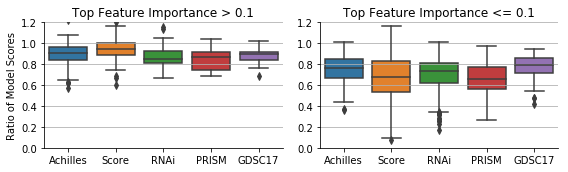

In [91]:
figure, axs = plt.subplots(1, 2, figsize=(8, 2.0))

plt.sca(axs[0])
sns.boxplot(data=perf_ratios2[perf_ratios2.keyfeature == 1], x='dataset', y='score')
print('With key feature, ratio median', perf_ratios2[perf_ratios2.keyfeature == 1]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("Ratio of Model Scores")
plt.xlabel('')
plt.title('Top Feature Importance > 0.1')
plt.ylim(0, 1.2)
                                
plt.sca(axs[1])
sns.boxplot(data=perf_ratios2[perf_ratios2.keyfeature == 0], x='dataset', y='score')
print('Without key feature, ratio median', perf_ratios2[perf_ratios2.keyfeature == 0]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("")
plt.xlabel('')
plt.title('Top Feature Importance <= 0.1') 
plt.ylim(0, 1.2)
                                
                                
plt.gcf().set_size_inches(8, 2.5)
plt.tight_layout()
plt.savefig('figures/two_feature_scores.png', dpi=600)

In [92]:
print((perf_ratios2[perf_ratios2.keyfeature == 0].score > .8).mean())

0.313944817300522


In [93]:
print((perf_ratios2[perf_ratios2.keyfeature == 1].score > .8).mean())

0.8361266294227188


## Fig. 4-2b: EN with only one feature

With key feature, ratio median 0.7994976881970535
Without key feature, ratio median 0.30592507753267933


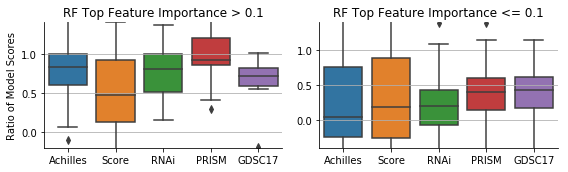

In [94]:
figure, axs = plt.subplots(1, 2, figsize=(8, 2.0))

plt.sca(axs[0])
sns.boxplot(data=perf_ratios_EN[perf_ratios_EN.keyfeature == 1], x='dataset', y='score')
print('With key feature, ratio median', perf_ratios_EN[perf_ratios_EN.keyfeature == 1]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("Ratio of Model Scores")
plt.xlabel('')
plt.title('RF Top Feature Importance > 0.1')
plt.ylim(-.2, 1.4)
                                
plt.sca(axs[1])
sns.boxplot(data=perf_ratios_EN[perf_ratios_EN.keyfeature == 0], x='dataset', y='score')
print('Without key feature, ratio median', perf_ratios_EN[perf_ratios_EN.keyfeature == 0]['score'].median())
sns.despine()
plt.grid(axis='y')
plt.ylabel("")
plt.xlabel('')
plt.title('RF Top Feature Importance <= 0.1') 
plt.ylim(-.4, 1.4)
                                
                                
plt.gcf().set_size_inches(8, 2.5)
plt.tight_layout()
plt.savefig('figures/one_feature_scores_EN.png', dpi=600)

## Fig. 4-2c: EN Feature Ablation

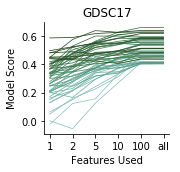

In [95]:
for name in data_names:
    val = main[name]['EN_score'].query('all > 0.4')
    pal = sns.cubehelix_palette(len(val), start=np.random.uniform(-2, 2), dark=.2, light=.7)
    plt.close('all')
    plt.figure(figsize=(2.6, 2.5))
    for i, ind in enumerate(val.sort_values('1').index):
        plt.plot(np.arange(val.shape[1]), val.loc[ind], color=pal[i], lw=.75)
    sns.despine()
    plt.xticks(range(val.shape[1]), val.columns)
    plt.xlabel("Features Used")
    plt.ylabel("Model Score")
    plt.title(name)
    plt.tight_layout()
    plt.savefig('figures/EN_feature_addition_score_%s.png' % name, dpi=600)

# Fig. 5: Removing Key Features

In [96]:
feature_change = {name: (removed_features[name] 
                    - main[name]['summary'].loc['Expression'].loc[
                        removed_features[name].index, 
                        'overall_pearson'
                    ])
                       for name in data_names}

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Achilles -27.34 505
correlation with unfiltered performance (-0.4146429800993494, 2.1049381867241044e-22)
correlation with feature0 importance (-0.4146429800993494, 2.1049381867241044e-22)
21 11
                             feature0  feature0_importance  overall_pearson
gene                                                                       
SLF1 (84250)       SIMC1 (375484)_Exp             0.476858         0.555092
DNAJC19 (131118)  DNAJC15 (29103)_Exp             0.527688         0.621500
FAM50A (9130)      FAM50B (26240)_Exp             0.721516         0.800423
MPL (4352)         ERMAP (114625)_Exp             0.103903         0.364740
INTS6 (26512)     INTS6L (203522)_Exp             0.497595         0.623239


Score -66.11 290
correlation with unfiltered performance (-0.5848392906942735, 5.2845470010054135e-28)
correlation with feature0 importance (-0.5848392906942735, 5.2845470010054135e-28)
12 0
                             feature0  feature0_importance  overall_pearson
gene

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


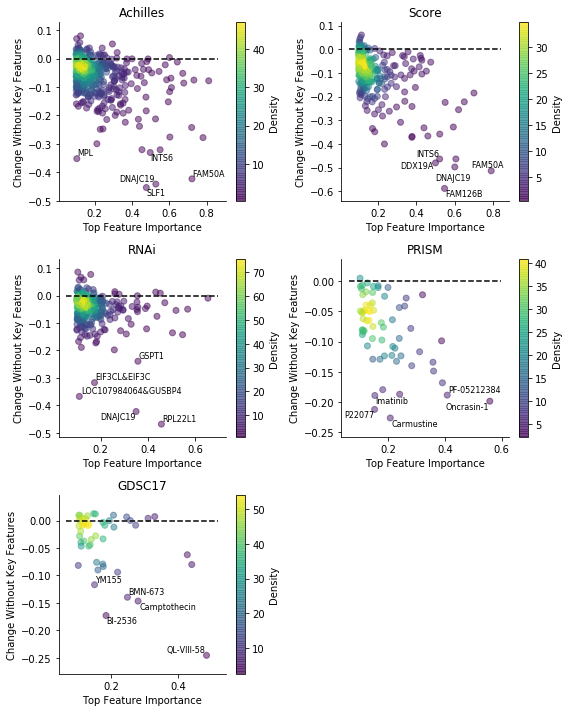

In [97]:
fig, axs = plt.subplots(3, 2, figsize=(8, 10))
axs = [a for ax in axs for a in ax]
total_below = 0
total_above = 0
for name, ax in zip(data_names, axs):
    plt.sca(ax)
    plt.title(name)
    y = feature_change[name]
    x = main[name]['summary'].loc['Expression'].loc[y.index, 'feature0_importance']
    total_below += (y < 0).sum()
    total_above += (y > 0).sum()
    outliers = y.sort_values().index[:5]
    arr = np.array([x.values, y.values])
    density = gaussian_kde(arr)(arr)
    plt.scatter(x, y, alpha=.5, linewidth=1, c=density)
    plt.colorbar(label="Density")
    plt.plot(plt.gca().get_xlim(), [0, 0], '--', color='black')
    if name in ['PRISM', 'GDSC17']:
        labels = {s: main[name]['pert_info']['Name'].drop_duplicates()[s]
                 for s in outliers}

    else:
        labels = {s: s.split(' ')[0] for s in outliers}
    texts = [plt.text(s=labels[s], x=x.loc[s], y=y.loc[s], fontsize=8)
              for s in outliers]
    adjust_text(texts, x=x, y=y)
    plt.ylabel("Change Without Key Features")
    plt.xlabel("Top Feature Importance")
    sns.despine(top=True, right=True)
    print(name, '%1.2f' % (100*y.median()/x.median()), len(y))
    print('correlation with unfiltered performance', pearsonr(x, y))
    feature0 = main[name]['summary'].loc['Expression'].loc[y.index, 'feature0_importance']
    print('correlation with feature0 importance', pearsonr(y, feature0 ))
    print((feature0 > .5).sum(), (y[feature0 > .5] > -.1).sum())
    print(main[name]['summary'].loc['Expression'].loc[labels, [
        'feature0', 'feature0_importance', 'overall_pearson'
    ]])
    if name == 'PRISM':
        print(main[name]['pert_info'].loc[labels, [
            'Name', 'moa', 'target', 'indication'
        ]].drop_duplicates())
    if name == 'GDSC17':
        print(main[name]['pert_info'].loc[labels, [
            'Name', 'Putative Target',  'Targeted process/pathway'
        ]])
    print('\n')
axs[-1].remove()
plt.tight_layout()
plt.savefig("figures/removing_key_expression.png", dpi=400)

In [98]:
print(total_below, total_above, total_below/(total_above + total_below))

1133 127 0.8992063492063492


# Fig. 6: Interpretable Models

## Additional Utility functions

In [99]:
def clamp(x): 
    return max(0, min(x, 255))

def hexcolor(r, g, b, alpha=1):
    if all([s <= 1.0 for s in (r, g, b)]):
        r = int(r*256)
        g = int(g*256)
        b = int(b*256)
    return "#{0:02x}{1:02x}{2:02x}".format(clamp(r), clamp(g), clamp(b))

In [100]:
import re
def split_label(s, split_char='_', length=15):
    if len(s) <= length:
        return s
    possible_splits = s.split(split_char)
    rows = []
    row = None
    for split in possible_splits:
        if not row:
            row = split
            continue
        if len(row) < length:
            row = '_'.join([row, split])
        else:
            rows.append(row)
            row = split
    rows.append(row)
    return '\\n'.join(rows)
            

In [101]:
cdict = {
    'red': [
        (0, .8, .8),
        (.6, 1, 1),
        (1, .3, .3)
    ],
    'green': [
        (0, .3, .3),
        (.6, 1, 1),
        (1, .4, .4)
    ],
    'blue': [
        (0, .1, .1),
        (.6, 1, 1),
        (1, .8, .8)
    ]
}

tree_cmap = LinearSegmentedColormap('DepTree', cdict)

In [102]:
def colorscale(x):
    return (np.clip(x, -1.5, 1) + 1.5)/2.5

In [103]:
def pearson_score(model, x, y, folds=10):
    splitter = KFold(folds, shuffle=True)
    splits = splitter.split(x)
    oos = 0 * y
    
    for train, test in splits:
        if isinstance(x, pd.DataFrame):
            model.fit(x.iloc[train], y.iloc[train])
            oos.iloc[test] = model.predict(x.iloc[test])
        else:
            model.fit(x[train], y[train])
            oos[test] = model.predict(x[test])
    return pearsonr(oos, y)[0]

In [104]:
def keep_features(summary_row, max_features=3, min_importance=.01, min_start_importance=.1):
    if summary_row['feature0_importance'] < min_start_importance:
        return []
    return [summary_row['feature%i' % i] for i in range(max_features) 
            if summary_row['feature%i_importance' %i] > min_importance]

In [105]:
def gene_label_responder(x):
    if x < -1:
        return "Strong Sensitivity"
    if x < -.5:
        return "Sensitivity"
    if x < -.25:
        return "Weak Sensitivity"
    if x < .25:
        return "Insensitive"
    return "Outgrowth"

def lfc_label_responder(x):
    if x < -2:
        return "Strong Sensitivity"
    if x < -1:
        return "Sensitivity"
    if x < -.5:
        return "Weak Sensitivity"
    if x < 1:
        return "Insensitive"
    return "Outgrowth"

def gdsc_label_responder(x):
    if x < .2:
        return "Strong Sensitivity"
    if x < .35:
        return "Sensitivity"
    if x < .5:
        return "Weak Sensitivity"
    return "Insensitive"

def edit_dot_data(dot_data, responder_labeling=None, color_scale_min=-1.5, color_scale_max=1, cmap=tree_cmap):
    lines = dot_data.split('\n')
    first = True
    for i in range(1, len(lines)-1):
        line = lines[i]
        if '->' in line:
            if 'False' in line:
                lines[i] = line.replace('False', 'True')
            else:
                lines[i] = line.replace('True', 'False')
            continue
            
        elif line.startswith('node') or line.startswith('edge'):
            continue
        #line is a node
        node_core = line.split('[')[1].split(']')[0].split(', ')
        #print(node_core)
        node_core = dict([v.split('="') for v in node_core])
        rows = node_core['label'].replace('"', '').strip().split('\\n')
        mean = float(rows[-1])
        if cmap is not None:
            color = hexcolor(*tree_cmap(np.clip(
                     (mean - color_scale_min)
                    /(color_scale_max - color_scale_min),
                0, 1)))
            node_core['fillcolor'] = color
        labeling = False
        if len(rows) < 4 and not responder_labeling is None:
            labeling = True
            try:
                rows.insert(0, responder_labeling(mean))
            except ValueError:
                print(line)
                print(rows)
                assert False
        if '<=' in rows[0]:
            rows[0] = rows[0].split('<=')[0]
        if rows[0].startswith("WARTERS_RESPONSE_TO_IR_SKIN_GSEA"):
            rows[0] = 'WARTERS_IR_SKIN' + ' '.join(rows[0].split(' ')[1:])
        elif '(' in rows[0] and ')' in rows[0]:
            rows[0] = rows[0].split('(')[0] + rows[0].split(')')[1]
        rows[0] = split_label(rows[0])
        if first:
            rows[2] = 'N = %i' % int(rows[2])
            rows[3] = 'Mean = %1.2f' % float(rows[3])
        if not labeling:
            node_core['label'] = '\\n'.join([rows[2], rows[3], rows[0].strip()])
        else:
            node_core['label'] = '\\n'.join([rows[2], rows[3]])
        lines[i] = line.split('[')[0] +\
                '[' + \
                ', '.join('%s="%s"' % tup for tup in node_core.items()) +\
                ']' + \
                line.split(']')[1]
                
            
        #print(lines[i])
    return '\n'.join(lines) 

In [106]:
def interpretable_models(summary, feature_matrix, target, tree_model,
                        responder_labeling=None, color_scale_min=-1.5, color_scale_max=1, cmap=tree_cmap
                        ):
    '''
    Parameters:
        summary (`pd.DataFrame`): ensemble prediction summary for a specific model, with genes as the index.
        feature_matrix (`pd.DataFrame`): matrix of features, will column names corresponding to entries
            in summary
        target (`pd.DataFrame`): target viability response indexed by cell line. Indices of summary must be
                present in the columns of target.
    Returns:
        {
            scores: OOS scores of either a decision tree or linear model with 10X validation. Note the decision 
                    trees get binarized data for continuous features, and the binary splits are picked with all
                    the data, so the cross-validation is not totally blind to the held-out data.
            trees: DOT-formatted graphs of the decision tree models. 
            binplots: arguments for calling binplot for the linear models.
        }
    '''
    features = summary.apply(keep_features, axis=1)
    all_features = sorted(set.union(*[set(v) for v in features.values]))
    
    scores = {}
    trees = {}
    binplots = {}
    
    stump = DecisionTreeRegressor(max_depth=1)
    linear = LinearRegression()
    for name, feat in features.iteritems():
        if len(feat) == 0:
            continue
        x = feature_matrix[feat].dropna(how='any', axis=0)
        y = target[name].dropna()
        shared = sorted(set(x.index) & set(y.index))
        if len(shared) < 20:
            continue
        x = x.loc[shared]
        y = y.loc[shared]
        tree_model.fit(x, y)
        nfeatures = len(set(tree_model.tree_.feature) - set([-2]))
        if nfeatures > 1:
            continuous = x.nunique().loc[lambda x: x > 2].index
            for v in continuous:
                stump.fit(x[[v]].values, y.values)
                threshold = np.round(stump.tree_.threshold[0], 2)
                x[v] = x[v] > threshold
                ind = list(x.columns).index(v)
                x.columns = list(x.columns[:ind]) + [v + ' > %1.2f' % threshold] + list(x.columns[ind+1:])
            tree_model.fit(x, y)
            trees[name] = edit_dot_data(
                export_graphviz(tree_model, None, feature_names=x.columns, label=name, 
                                filled=True, rounded=True
                               ),
                responder_labeling, color_scale_min, color_scale_max, cmap
            )
            scores[name] = pearson_score(tree_model, x.values, y.values)
        else:
            scores[name] = pearson_score(linear, x.values, y.values)
            binplots[name] = dict(
                scatter=dict(x=x.iloc[:, 0], y=y), 
                xlabel=x.columns[0], ylabel=name
            )
            
    return {'scores': scores, 'trees': trees, 'binplots': binplots}

## Highlighted Perturbations

In [107]:
main['PRISM']['pert_info'].drop_duplicates(inplace=True)

In [108]:
perts = ['MDM2 (4193)', 'TP53 (7157)', 'PARD6B (84612)',
         'Nutlin', 'Idasanutlin', 'Vemurafenib', 'Dabrafenib', 
        ]
def pert_lookup(s):
    s = str(s)
    for pert in perts:
        if s.startswith(pert):
            return True
    return False

In [109]:
interpretable = {}
for name in data_names:

    if name in ('PRISM', 'GDSC17'):
        perts2 = main[name]['pert_info'].index[
            main[name]['pert_info']['Name'].apply(pert_lookup)
        ]
    else:
        perts2 = perts
    summary = main[name]['summary'].loc['All Features']
    
    # comment the following line and uncomment the next to generate an interpretable model for all 
    # perturbations with an all-feature predictor scoring above 0.4 and a key feature,
    # rather than just those highlighted in the paper. This may take some time.
    summary = summary[summary.index.isin(perts2)]
#   summary = summary.query('overall_pearson > .4').query('feature0_importance > .1')
    
    print(name, '\n', summary['overall_pearson'])
    
    feat = read_hdf5(join(figshare, name+"Features.hdf5"))
    observed = main[name]['y'][summary.index]
    if observed.shape[1] == 0:
        continue
    std = observed.stack().std()
    model = DecisionTreeRegressor(max_depth=4, min_impurity_decrease=std/50, min_samples_leaf=5)
    print(name, len(summary), observed.shape, std)
    
    if name in ['Achilles', 'Score', 'RNAi']:
        responder_labeling = gene_label_responder
        color_scale_min=-1.5
        color_scale_max=1
        
    elif name == 'GDSC17':
        responder_labeling = gdsc_label_responder
        color_scale_min=0
        color_scale_max=1
        summary = summary.copy()
        summary.index = main[name]['pert_info'].loc[summary.index, 'Name'].drop_duplicates()
        observed = observed.copy()
        observed.columns = summary.index
        
    elif name == 'PRISM':
        responder_labeling = lfc_label_responder
        color_scale_min=-3
        color_scale_max=2
        summary = summary.copy()
        summary.index = main[name]['pert_info'].loc[summary.index, 'Name'].drop_duplicates()
        observed = observed.copy()
        observed.columns = summary.index
        
    interpretable[name] = interpretable_models(summary, feat, observed, model,
                                             responder_labeling, color_scale_min, color_scale_max
                                             )
    del feat

Achilles 
 gene
MDM2 (4193)       0.767779
PARD6B (84612)    0.587798
TP53 (7157)       0.713595
Name: overall_pearson, dtype: float64
Achilles 3 (693, 3) 0.6000279171246906
Score 
 gene
MDM2 (4193)       0.560042
PARD6B (84612)    0.476231
TP53 (7157)       0.638605
Name: overall_pearson, dtype: float64


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


Score 3 (241, 3) 0.35723457828873595
RNAi 
 gene
MDM2 (4193)       0.766509
PARD6B (84612)    0.128126
TP53 (7157)       0.725269
Name: overall_pearson, dtype: float64
RNAi 3 (655, 3) 0.3670603757979505
PRISM 
 gene
BRD-A12230535-001-06-7    0.457015
BRD-K09951645-001-06-8    0.527914
BRD-K56343971-001-10-6    0.426450
BRD-K62627508-001-01-5    0.749466
Name: overall_pearson, dtype: float64
PRISM 4 (571, 4) 0.935088563171694
GDSC17 
 gene
1047    0.736246
1373    0.600266
Name: overall_pearson, dtype: float64
GDSC17 2 (674, 2) 0.24724799562402508


In [110]:
interpretable_path = join('figures', 'interpretable_models')
if not os.path.isdir(interpretable_path):
    os.mkdir(interpretable_path)

Achilles
saving figures/interpretable_models/Achilles/MDM2 (4193)
saving figures/interpretable_models/Achilles/TP53 (7157)
Score
saving figures/interpretable_models/Score/MDM2 (4193)
saving figures/interpretable_models/Score/TP53 (7157)
RNAi
saving figures/interpretable_models/RNAi/MDM2 (4193)
saving figures/interpretable_models/RNAi/TP53 (7157)
PRISM
saving figures/interpretable_models/PRISM/Nutlin-3
saving figures/interpretable_models/PRISM/Dabrafenib
saving figures/interpretable_models/PRISM/Idasanutlin
GDSC17
saving figures/interpretable_models/GDSC17/Nutlin-3a


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserW

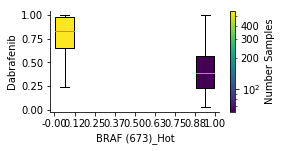

In [111]:
for key, val in interpretable.items():
    print(key)
    sub_path = join(interpretable_path, key)
    if not os.path.isdir(sub_path):
        os.mkdir(sub_path)
    for name, value in val['trees'].items():
        graph = Source(value)
        print('saving', join(sub_path, name))
        graph.render(join(sub_path, name))
    for name, value in val['binplots'].items():
        plt.close('all')
        plt.figure(figsize=(4.0, 2.2))
        binplot(**value['scatter'], nbins=8)
        xlabel = value['xlabel']
        
        plt.xlabel(xlabel)
        plt.ylabel(value['ylabel'])
        plt.xticks(rotation=0)
        if key in ['Achilles', 'Score', 'RNAi']:
            plt.plot(plt.gca().get_xlim(), [0, 0], '--', color='black')
            plt.plot(plt.gca().get_xlim(), [-1, -1], '--', color='red')
            plt.ylabel(value['ylabel'].split(' ')[0] + 'Gene Effect')
            plt.xlabel(value['xlabel'].split(' ')[0] + 'Expression (log2(TPM+1))')
        sns.despine(top=True, right=True)
        plt.tight_layout()
        plt.savefig(join(sub_path, name) + ".pdf")

## Fig. 6c, 6-1: p53/MDM2

Achilles
	EDA2R exp and TP53 dep (0.6367560326830607, 4.541112958018131e-80) 693
	EDA2R exp and MDM2 dep (-0.6617781302722979, 1.6132380927559105e-88) 693
Score
	EDA2R exp and TP53 dep (0.5463226084969235, 3.744081518623566e-20) 241
	EDA2R exp and MDM2 dep (-0.465222165651052, 2.401683694985112e-14) 241
RNAi
	EDA2R exp and TP53 dep (0.6202814887915288, 6.702406586736879e-71) 655
	EDA2R exp and MDM2 dep (-0.6162245631213006, 9.561044317078795e-70) 655


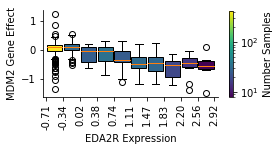

In [112]:
for name in ['Achilles', 'Score', 'RNAi']:
    print(name)
    x = read_hdf5(join(figshare, name + 'Features.hdf5'))['EDA2R (60401)_Exp'].dropna()
    for gene in 'TP53 (7157)', 'MDM2 (4193)':
        y = main[name]['y'][gene].dropna()
        shared = sorted(set(x.index) & set(y.index))
        print('\tEDA2R exp and %s dep' % gene.split(' ')[0], pearsonr(x.loc[shared], y.loc[shared]), len(shared))
        plt.close('all')
        plt.figure(figsize=(4, 2.2))
        binplot(x.loc[shared], y.loc[shared])
        plt.xticks(rotation=90)
        plt.xlabel("EDA2R Expression")
        plt.ylabel("%s Gene Effect" % gene.split(' ')[0])
        sns.despine(top=True, right=True)
        plt.tight_layout()
        plt.savefig(join('figures', 'interpretable_models', name, '%s_EDA2R_Exp.png' % (gene.split(' ')[0])),
                    dpi=600)

PRISM
	EDA2R exp and Nutlin-3 vulnerability (-0.3576858786437869, 7.313609406773771e-18) 544
	EDA2R exp and Idasanutlin vulnerability (-0.5778997546599071, 9.73491548649817e-52) 566
GDSC17
	EDA2R exp and Nutlin-3a vulnerability (-0.4949925173269823, 1.3402153327426754e-34) 538


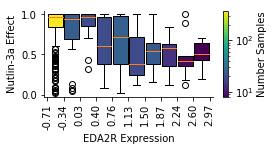

In [113]:
for name in ['PRISM', 'GDSC17']:
    print(name)
    x = read_hdf5(join(figshare, name+"Features.hdf5"))['EDA2R (60401)_Exp'].dropna()
    for drug in 'Nutlin', 'Idasanutlin':
        drug_name = [s for s in main[name]['pert_info']['Name'] if str(s).startswith(drug)]
        if len(drug_name) == 0:
            continue
        drug = main[name]['pert_info'].query('Name == %r' % drug_name).index[0]
    
        y = main[name]['y'][drug].dropna()
        shared = sorted(set(x.index) & set(y.index))
        print('\tEDA2R exp and %s vulnerability' % drug_name[0], 
              pearsonr(x.loc[shared], y.loc[shared]), len(shared))
        plt.close('all')
        plt.figure(figsize=(4, 2.2))
        binplot(x.loc[shared], y.loc[shared])
        plt.xticks(rotation=90)
        plt.xlabel("EDA2R Expression")
        plt.ylabel("%s Effect" % drug_name[0])
        sns.despine(top=True, right=True)
        plt.tight_layout()
        plt.savefig(join('figures', 'interpretable_models', name, 
                         '%s_EDA2R.png' % drug_name[0]
                        ), dpi=600
                   )

## Fig. 6-2: BRAF Inhibitors vs RXRG in subcontexts

PRISM hot N=59 RXRG correlation with Dabrafenib sensitivity (-0.41818529734583987, 0.0009812128864018091)


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


PRISM melanoma N=38 RXRG correlation with Dabrafenib sensitivity (-0.4110416454618075, 0.010358851308206114)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


PRISM melanoma_hot N=30 RXRG correlation with Dabrafenib sensitivity (-0.3463771773822327, 0.06078028504203376)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


PRISM hot N=63 RXRG correlation with Vemurafenib sensitivity (-0.49516149618507216, 3.695965100674975e-05)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


PRISM melanoma N=42 RXRG correlation with Vemurafenib sensitivity (-0.25278308221701257, 0.10628135169667459)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


PRISM melanoma_hot N=33 RXRG correlation with Vemurafenib sensitivity (-0.1614725810701252, 0.3693272111829081)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


GDSC17 hot N=61 RXRG correlation with Dabrafenib sensitivity (-0.44280586070495637, 0.00035218871837762526)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


GDSC17 melanoma N=31 RXRG correlation with Dabrafenib sensitivity (-0.018274424475463843, 0.9222702514366019)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


GDSC17 melanoma_hot N=25 RXRG correlation with Dabrafenib sensitivity (-0.05047216433402558, 0.8106455712280098)


/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


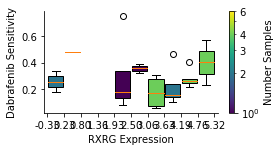

In [114]:
for name in "PRISM", "GDSC17":
    feat = read_hdf5(join(figshare, name + "Features.hdf5"))
    contexts = {'hot': feat.index[feat['BRAF (673)_Hot'] == 1], 
               'melanoma': lineages.reindex(index=main[name]['y'].index).query(
                   "lineage_subtype == 'melanoma'"
               ).index}
    contexts['melanoma_hot'] = sorted(set(contexts['melanoma']) & set(contexts['hot']))
    for drugroot in 'Dabrafenib', 'Vemurafenib':
        for context, sub in contexts.items():
            info = main[name]['pert_info'].query('Name == %r' % drugroot)
            if len(info) == 0:
                continue
            drug = info.index[0]
            drug_sensitivity = main[name]['y'][drug]   
            drug_sensitivity_sub = drug_sensitivity.reindex(
                index=sorted(set(drug_sensitivity.dropna().index) & set(feat.index) & set(sub))
            )

            print(name, context, "N=%i" % len(drug_sensitivity_sub),
                  "RXRG correlation with %s sensitivity" % drugroot,
                 pearsonr(feat['RXRG (6258)_Exp'].reindex(index=drug_sensitivity_sub.index),
                          drug_sensitivity_sub)
                 )

            plt.close('all')
            binplot(feat['RXRG (6258)_Exp'].reindex(index=drug_sensitivity_sub.index), 
                    drug_sensitivity_sub)
            plt.xlabel("RXRG Expression")
            plt.ylabel("%s Sensitivity" % drugroot)
            plt.gcf().set_size_inches((4, 2.2))
            sns.despine(top=True, right=True)
            plt.tight_layout()
            plt.savefig(join(interpretable_path, name, "%s_rxrg_%s.png" % (drugroot, context)), dpi=600)
    del feat

## BRAF vs RXRG in Melanoma

45
Achilles RXRG correlation with BRAF sensitivity within melanoma lines (-0.3740809836543162, 0.011359269329033254)
43
RNAi RXRG correlation with BRAF sensitivity within melanoma lines (-0.3856957167483422, 0.010639182663601043)


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])


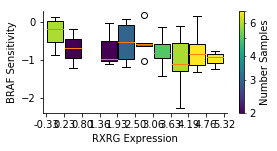

In [115]:
for name in "Achilles", "RNAi":
    feat = read_hdf5(join(figshare, name + "Features.hdf5"))
    y = main[name]['y']['BRAF (673)']
    sub = lineages.loc[y.index].query("lineage_subtype == 'melanoma'").index
    print(len(sub))
    print(name, "RXRG correlation with BRAF sensitivity within melanoma lines",
         pearsonr(feat['RXRG (6258)_Exp'].loc[sub], y.loc[sub])
         )

    plt.close('all')
    binplot(feat['RXRG (6258)_Exp'].loc[sub], y.loc[sub])
    plt.xlabel("RXRG Expression")
    plt.ylabel("%s Sensitivity" % 'BRAF')
    plt.gcf().set_size_inches((4, 2.2))
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig(join(interpretable_path, name, "%s_RXRG_melanoma.png" % 'BRAF'), dpi=600)
        
    del feat

## Fig. 6-3: PARD6B in OV and PANC

Achilles
	PARD6B exp and PARD6B dep (-0.44398657983602696, 7.730202271250618e-35) 693
	PARD6B exp and PARD6B dep in OV and PANC (-0.5529498535490119, 1.4758484199396593e-06) 66
Score
	PARD6B exp and PARD6B dep (-0.365169767368012, 5.142389090845625e-09) 241
	PARD6B exp and PARD6B dep in OV and PANC (-0.43405119379132706, 0.0028922470896164754) 45
RNAi
	PARD6B exp and PARD6B dep (-0.3094773450609095, 2.7755856717428503e-08) 309
	PARD6B exp and PARD6B dep in OV and PANC (-0.558687114643262, 0.24916119351289442) 6


/Users/dempster/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:73: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserWarning: Warning: converting a masked element to nan.
  xa = np.array([X])
/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:478: UserW

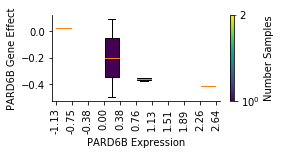

In [116]:
for name in ['Achilles', 'Score', 'RNAi']:
    print(name)
    x = read_hdf5(join(figshare, name + 'Features.hdf5'))['PARD6B (84612)_Exp'].dropna()
    gene = 'PARD6B (84612)'
    y = main[name]['y'][gene].dropna()
    shared = sorted(set(x.index) & set(y.index))
    sub = lineages.loc[shared, 'lineage'].loc[lambda x: x.isin(['ovary', 'pancreas'])].index
    print('\tPARD6B exp and %s dep' % gene.split(' ')[0], 
          pearsonr(x.loc[shared], y.loc[shared]), len(shared))
    print('\tPARD6B exp and %s dep in OV and PANC' % gene.split(' ')[0], 
          pearsonr(x.loc[sub], y.loc[sub]), len(sub))
    
    plt.close('all')
    plt.figure(figsize=(4, 2.2))
    binplot(x.loc[shared], y.loc[shared])
    plt.xticks(rotation=90)
    plt.xlabel("PARD6B Expression")
    plt.ylabel("%s Gene Effect" % gene.split(' ')[0])
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig(join('figures', 'interpretable_models', name, '%s.png' % (gene.split(' ')[0])),
                dpi=600)
    
    plt.close('all')
    plt.figure(figsize=(4, 2.2))
    binplot(x.loc[sub], y.loc[sub])
    plt.xticks(rotation=90)
    plt.xlabel("PARD6B Expression")
    plt.ylabel("%s Gene Effect" % gene.split(' ')[0])
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig(join('figures', 'interpretable_models', name, '%s_OVPANC.png' % (gene.split(' ')[0])),
                dpi=600)

# Discussion: CFE enrichment for Sanger drugs

In [117]:
# You will need supplementary table 2 from Iorio et. al. 2016: 
# https://doi.org/10.1016/j.cell.2016.06.017
cfe_cancer_genes = pd.read_csv('S2 - CFEs - cancer genes.csv', skiprows=1)

In [118]:
cfe_cancer_gene_set = set(cfe_cancer_genes['Gene'])

In [119]:
drug_target_in_cfe = main['GDSC17']['pert_info'].apply(lambda x:
                                                      len(set([v.strip() for v in x['target'].split(',')])
                                                          & cfe_cancer_gene_set) > 0
                                                       , axis=1)

In [120]:
drug_target_in_cfe.mean()

0.2037735849056604

In [121]:
drug_target_in_cfe.sum()

54

In [122]:
len(cfe_cancer_gene_set)

472